## Import

In [ ]:
import sys; sys.path.insert(0, '..')
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tabulate import tabulate
from utils.df_utils import df_wrapper
from dataclasses import dataclass
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from utils.declarations import training_files, testing_files, POSE_MAP

## Define data

In [ ]:
AMOUNT_OF_SENSORS = 3
VALIDATION_TESTSET = "004"

## Datapreparation

#### Train

In [ ]:
x_train_arr = []
for key in training_files:
    elem = df_wrapper(training_files[key].csv_file)
    elem.concat_sensor_data(AMOUNT_OF_SENSORS)
    elem.align_poses(training_files[key].annot_file, POSE_MAP)
    x_train_arr.append(elem)

x_train = pd.concat([x.df.drop([' TimeStamp (s)', 'Pose'],axis=1) for x in x_train_arr])
y_train = pd.concat([x.df['Pose'] for x in x_train_arr])

../utils/df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
../utils/df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
../utils/df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

### Test


In [ ]:
x_test_dict = dict()
y_test_dict = dict()
for key in testing_files:
    elem = df_wrapper(testing_files[key].csv_file)
    elem.concat_sensor_data(AMOUNT_OF_SENSORS)
    elem.align_poses(testing_files[key].annot_file, POSE_MAP)
    y_test = elem.df["Pose"]
    y_test.index = [i for i in range(len(y_test))]
    x_test_dict[key] = elem.df
    y_test_dict[key] = y_test

x_test = x_test_dict[VALIDATION_TESTSET].drop([' TimeStamp (s)', 'Pose'], axis=1) 
y_test = y_test_dict[VALIDATION_TESTSET]

../utils/df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
../utils/df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
../utils/df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

## Visualisation

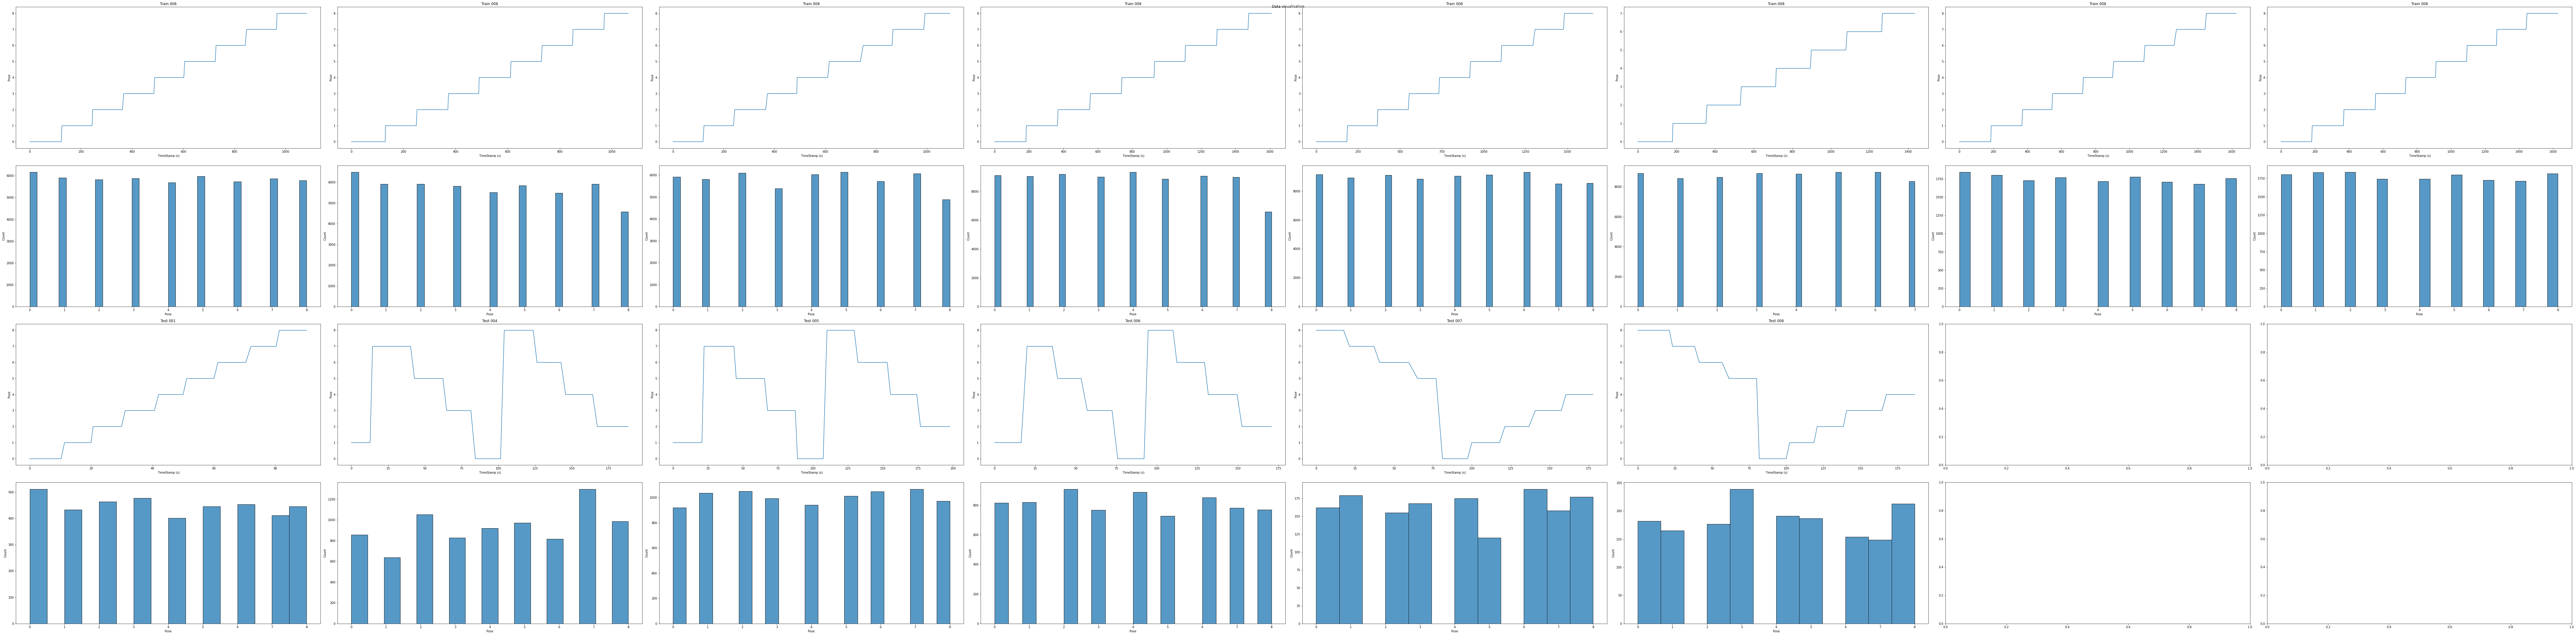

In [ ]:
cols = []
height=30
width=(height/2)*len(x_train_arr)
fig, axes = plt.subplots(4, len(x_train_arr), figsize=(width, height))
fig.suptitle('Data visualisation')
# Train
for i in range(len(x_train_arr)):
    sns.lineplot(ax=axes[0, i], data=x_train_arr[i].df, x=" TimeStamp (s)", y='Pose')
    sns.histplot(ax=axes[1, i], data=x_train_arr[i].df["Pose"])
    cols.append(f'Train {key}')    
for ax, col in zip(axes[0], cols):
    ax.set_title(col)
# Test
cols=[]
for i, key in enumerate(x_test_dict):
    sns.lineplot(ax=axes[2, i], data=x_test_dict[key], x=" TimeStamp (s)", y='Pose')
    sns.histplot(ax=axes[3, i], data=y_test_dict[key])
    cols.append(f'Test {key}')
for ax, col in zip(axes[2], cols):
    ax.set_title(col)
fig.tight_layout()
plt.show()

## Adjust dataframes

In [ ]:
x_train_numpy = x_train.values
x_test_numpy = x_test.values
y_train_numpy = y_train.values
y_test_numpy = y_test.values

### GridSearch

In [ ]:

n_estimators_lst = [i for i in range(75, 125)]
parameters = {'n_estimators':n_estimators_lst} 
rfc = RandomForestClassifier(random_state=69)
clf = GridSearchCV(rfc, parameters, n_jobs=-1)
clf.fit(x_train, y_train)


"\nn_estimators_lst = [i for i in range(75, 125)]\nparameters = {'n_estimators':n_estimators_lst} \nrfc = RandomForestClassifier(random_state=69)\nclf = GridSearchCV(rfc, parameters, n_jobs=-1)\nclf.fit(x_train, y_train)\n"

## RFC            

In [ ]:
pipe = make_pipeline(RandomForestClassifier(n_estimators=150, random_state=42))
pipe.fit(x_train,y_train)

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(n_estimators=150, random_state=42))])

## Precision

In [ ]:
print("Classification accuracy:")
classification_dict = dict()
accuracy_list = list()

for key in x_test_dict:
    x_test = x_test_dict[key].drop([' TimeStamp (s)', 'Pose'], axis=1)
    classifications = pipe.predict(x_test)
    annotated_positions = y_test_dict[key].to_numpy()
    correct_classifications = (classifications == annotated_positions).sum()
    accuracy_list.append(round(correct_classifications/len(classifications)*100,2))
    print(f"{key}: {accuracy_list[-1]}%")
    classification_dict[key] = classifications

print(f"Average accuracy: {round(sum(accuracy_list)/len(accuracy_list),2)}")

Classification accuracy:
001: 99.98%
004: 83.59%
005: 78.49%
006: 84.39%
007: 98.31%
008: 77.43%


## Visualization


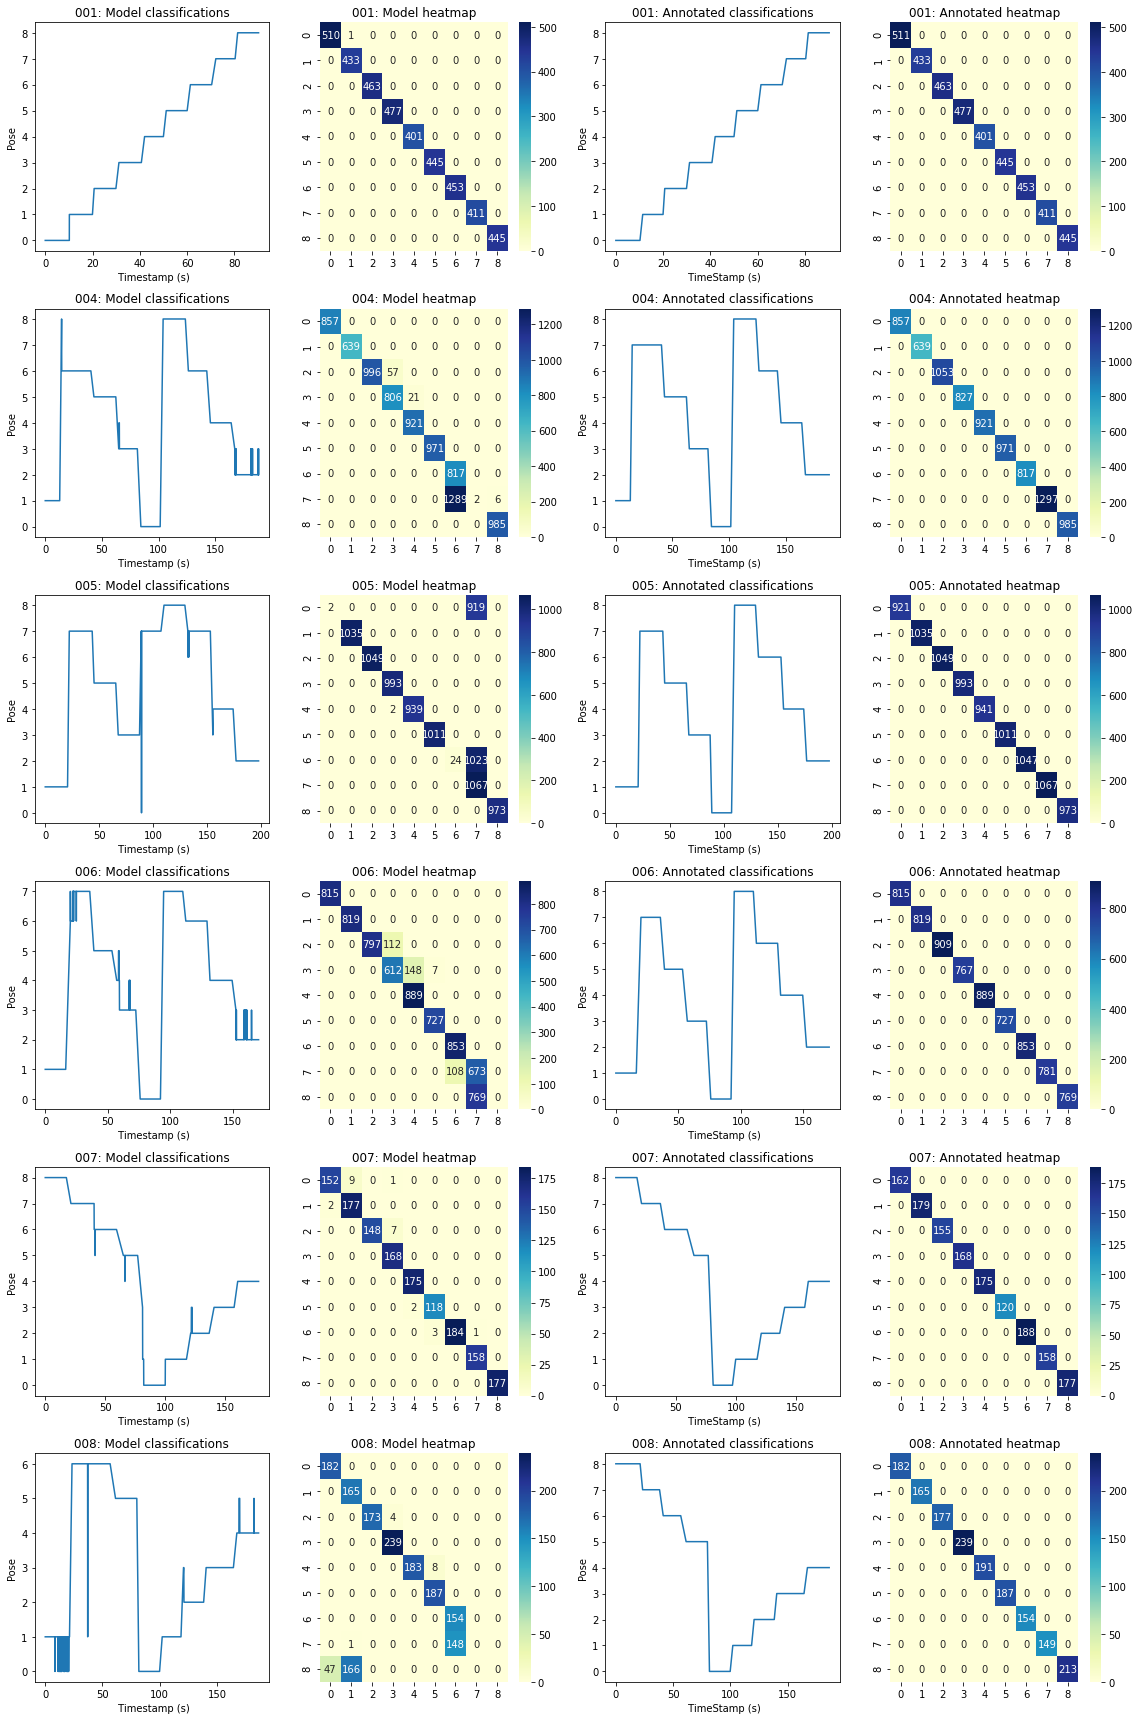

In [ ]:
width=16
height=4*len(x_test_dict)
fig, axes = plt.subplots(len(x_test_dict), 4, figsize=(width, height))
for i, key in enumerate(x_test_dict):
    cols = [f"{key}: Model classifications", f"{key}: Model heatmap", f"{key}: Annotated classifications", f"{key}: Annotated heatmap"]
    df_predict = pd.DataFrame({' Timestamp (s)': x_test_dict[key][' TimeStamp (s)'],'Pose':classification_dict[key]})
    sns.lineplot(ax=axes[i, 0], data=df_predict,x=' Timestamp (s)',y='Pose')
    sns.heatmap(ax=axes[i, 1], data=confusion_matrix(y_test_dict[key], classification_dict[key]), cmap="YlGnBu", annot=True, fmt="d")
    sns.lineplot(ax=axes[i, 2], data=x_test_dict[key], x=" TimeStamp (s)", y='Pose')
    sns.heatmap(ax=axes[i, 3], data=confusion_matrix(y_test_dict[key], y_test_dict[key].to_numpy()), cmap="YlGnBu", annot=True, fmt="d")
    for ax, col in zip(axes[i], cols): ax.set_title(col)
fig.tight_layout()
plt.show()

## Classification matrix and report

In [ ]:
#print(confusion_matrix(y_test, predictions))
#print(classification_report(y_test, predictions, zero_division=True))

In [ ]:

from joblib import dump, load
dump(pipe, f'../models/RFC_model_{AMOUNT_OF_SENSORS}.joblib')


"\nfrom joblib import dump, load\ndump(pipe, f'../models/RFC_model_{AMOUNT_OF_SENSORS}.joblib')\n"

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=59d486bc-e14d-4632-9064-12272fc72d11' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>